In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision
import torchvision.utils as vutils

In [2]:
class VAE(nn.Module):
    """
    Variational Autoencoder (VAE) for image reconstruction.
    Includes encoder, reparameterization trick, and decoder.
    """
    def __init__(self, latent_dim=128, img_channels=3):
        super(VAE, self).__init__()

        # Encoder: Downsampling the image into a latent vector
        self.encoder = nn.Sequential(
            nn.Conv2d(img_channels, 32, 4, 2, 1),  # Output: [B, 32, 128, 128]
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, 4, 2, 1),            # Output: [B, 64, 64, 64]
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),           # Output: [B, 128, 32, 32]
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1),          # Output: [B, 256, 16, 16]
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, 2, 1),          # Output: [B, 512, 8, 8]
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 512, 4, 2, 1),          # Output: [B, 512, 4, 4]
            nn.LeakyReLU(0.2)
        )

        # Latent space
        self.fc_mu = nn.Linear(512 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(512 * 4 * 4, latent_dim)

        # Decoder: Upsampling the latent vector to image
        self.fc_decode = nn.Linear(latent_dim, 512 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 512, 4, 2, 1),  # [B, 512, 8, 8]
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(512, 256, 4, 2, 1),  # [B, 256, 16, 16]
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # [B, 128, 32, 32]
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),   # [B, 64, 64, 64]
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),    # [B, 32, 128, 128]
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),     # [B, 3, 256, 256]
            nn.Tanh()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z):
        x = self.fc_decode(z)
        x = x.view(x.size(0), 512, 4, 4)
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

In [3]:
def loss_function(x, recon, mu, logvar):
    """
    VAE Loss = Reconstruction Loss + β * KL Divergence
    """
    beta = 0.1
    recon_loss = F.mse_loss(recon, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    return recon_loss + kl_div * beta

In [4]:
def train_model(model, optimizer, dataloader, device, num_epoch):
    """
    Train the VAE model.
    """
    model.train()
    losses = []
    for epoch in range(num_epoch):
        total_loss = 0
        print(f"\nEpoch {epoch + 1}/{num_epoch}")
        for i, (images, _) in enumerate(dataloader):
            images = images.to(device)

            # Forward pass
            recon, mu, logvar = model(images)

            # Compute loss
            loss = loss_function(images, recon, mu, logvar)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        avg_loss = total_loss / len(dataloader)
        losses.append(avg_loss)
        print(f"==> Epoch [{epoch+1}/{num_epoch}] - Average Loss: {avg_loss:.4f}")
    return model, losses

In [5]:
def evaluate_model(model, dataloader, device, num_samples=10):
    """
    Show real vs reconstructed images.
    """
    model.eval()
    real_images, _ = next(iter(dataloader))
    samples = real_images[:num_samples].to(device)

    with torch.no_grad():
        recon, _, _ = model(samples)

    # Denormalize [-1, 1] -> [0, 1]
    generated_images = recon * 0.5 + 0.5
    samples = samples * 0.5 + 0.5

    real_grid = vutils.make_grid(samples.cpu(), nrow=5, padding=2)
    generated_grid = vutils.make_grid(generated_images.cpu(), nrow=5, padding=2)

    fig, axes = plt.subplots(2, 1, figsize=(12, 6))
    axes[0].imshow(real_grid.permute(1, 2, 0))
    axes[0].set_title("Real Images")
    axes[0].axis("off")

    axes[1].imshow(generated_grid.permute(1, 2, 0))
    axes[1].set_title("Reconstructed Images")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

Training on device: cuda


100%|██████████| 345M/345M [00:14<00:00, 23.5MB/s]
100%|██████████| 502/502 [00:00<00:00, 1.06MB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 23.4MB/s]



Epoch 1/750
==> Epoch [1/750] - Average Loss: 16467228.2500

Epoch 2/750
==> Epoch [2/750] - Average Loss: 16410869.0000

Epoch 3/750
==> Epoch [3/750] - Average Loss: 16196562.2500

Epoch 4/750
==> Epoch [4/750] - Average Loss: 15796990.5000

Epoch 5/750
==> Epoch [5/750] - Average Loss: 15330459.2500

Epoch 6/750
==> Epoch [6/750] - Average Loss: 14945179.0000

Epoch 7/750
==> Epoch [7/750] - Average Loss: 14551171.7500

Epoch 8/750
==> Epoch [8/750] - Average Loss: 14152280.0000

Epoch 9/750
==> Epoch [9/750] - Average Loss: 13696040.7500

Epoch 10/750
==> Epoch [10/750] - Average Loss: 13125787.5000

Epoch 11/750
==> Epoch [11/750] - Average Loss: 12639389.5000

Epoch 12/750
==> Epoch [12/750] - Average Loss: 12172695.7500

Epoch 13/750
==> Epoch [13/750] - Average Loss: 11710983.7500

Epoch 14/750
==> Epoch [14/750] - Average Loss: 11096804.5000

Epoch 15/750
==> Epoch [15/750] - Average Loss: 10654987.5000

Epoch 16/750
==> Epoch [16/750] - Average Loss: 10277963.2500

Epoch 17/

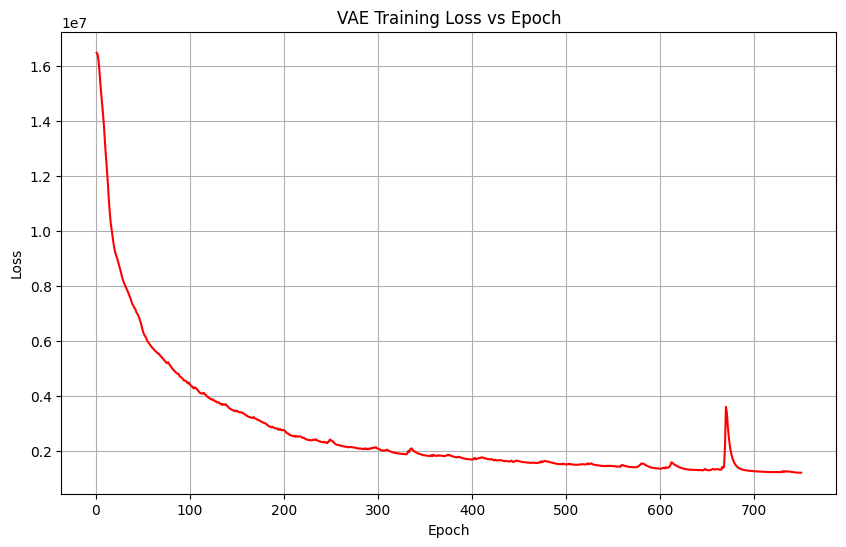

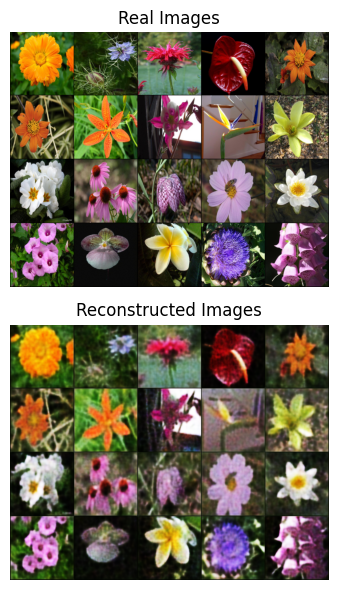

In [6]:
if __name__ == "__main__":
    batch_size = 256
    lr = 0.0001
    num_epoch = 750
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Training on device: {device}")

    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5] * 3, [0.5] * 3)
    ])

    # Load dataset
    train_data = torchvision.datasets.Flowers102(root="data/", split="train", download=True, transform=transform)
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    # Initialize model
    model = VAE(latent_dim=256, img_channels=3).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Train
    trained_model, losses = train_model(model, optimizer, train_dataloader, device, num_epoch)

    # Plot loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(losses)+1), losses, color='red')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("VAE Training Loss vs Epoch")
    plt.grid(True)
    plt.show()

    # Evaluate
    evaluate_model(trained_model, train_dataloader, device, num_samples=20)

